In [1]:
# run this cell only once
import os
os.chdir("..")

In [2]:
from collections import defaultdict

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
from torchvision import transforms

from eval_net import extract_feature
from config.config_parser import get_default_cfg, merge_cfg_from_file, \
    get_dataloader_from_cfg, get_model_from_cfg, get_parameters_from_cfg

In [3]:
# setup parameters, change according your needs
config_file = "results/DETR_queries_64_CASIA_no_encoder_8/config.yaml"
weight = "results/DETR_queries_64_CASIA_no_encoder_8/epoch_9.pt"
mcp_weight = "results/DETR_queries_64_CASIA_no_encoder_8/mcp_epoch_9.pt"

dataset_name = "casia"
device = "cuda" if torch.cuda.is_available() else "cpu"

# get the configurations
cfg = get_default_cfg()
cfg = merge_cfg_from_file(cfg, config_file)
cfg["DATASETS"]["TRAIN"] = [dataset_name] 
cfg["DATASETS"]["VAL"] = [""] # No need val set
cfg["DATASETS"]["TEST"] = [""] # No need test set
cfg["SOLVER"]["BATCH_SIZE"] = 1

# get model and dataloader
model, classifier, _ = get_model_from_cfg(cfg)
model.load_state_dict(torch.load(weight))
model.eval()

classifier.load_state_dict(torch.load(mcp_weight))
classifier.eval()

# freeze parameters
for p in model.parameters():
    p.requires_grad = False
    
for p in classifier.parameters():
    p.requires_grad = False
    
num_images, data_loaders, *_ = get_dataloader_from_cfg(cfg)
data_loader_iter = iter(data_loaders[0])

In [ ]:
def predict(model, classifier, image, label, device = 'cuda'):
    model.to(device)
    classifier.to(device)
    
    conv_features, dec_attn_weights = [], []
    
    hooks = [
        model.backbone[-2].register_forward_hook(
            lambda self, input, output: conv_features.append(output)
        ),
        model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
            lambda self, input, output: dec_attn_weights.append(output[1])
        ),
    ]

    image, label = image.to(device), label.to(device)
    outputs = model(image)
    feature, additional_loss, additional_output = model(image)
    
    score = classifier(feature["features"], label)
    score_prob = F.softmax(score, dim = 1)
    pred = torch.max(score_prob, dim = 1).indices.to("cpu")
    
    for hook in hooks:
        hook.remove()

    conv_features = conv_features[0]
    dec_attn_weights = dec_attn_weights[0]
    
    return pred, conv_features, dec_attn_weights

In [ ]:
to_PIL = transforms.Compose([
    transforms.Normalize(mean = (0, 0, 0), std = (1/0.5, 1/0.5, 1/0.5)),
    transforms.Normalize(mean = (-0.5, -0.5, -0.5), std = (1, 1, 1)),
    transforms.ToPILImage()
])

data, label = next(data_loader_iter)
img = to_PIL(torch.squeeze(data.detach().clone()))

# make predictions
pred, *outputs = predict(model, classifier, data, label, device = device)
h, w = outputs[0]['0'].tensors.shape[-2:]
dec_attn_weights = torch.squeeze(outputs[-1]).to("cpu").numpy()

# visualize the result
fig, ax = plt.subplots(8,8, figsize = (16,16))
ax = ax.flat
# cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i in range(len(ax)):
    sns.heatmap(dec_attn_weights[i].reshape(h, w), cmap = "coolwarm", ax = ax[i], cbar = False)

for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])
plt.show()

print(f"Ground truth: {label.item()}")
print(f"Prediction: {pred.item()}")

In [ ]:
idx = 24

fig, ax = plt.subplots(1,2, figsize = (12,6))
cbar_ax = fig.add_axes([.91, .3, .03, .4])
ax[0].imshow(img, aspect = "auto")
ax[0].set_title("Image")

sns.heatmap(dec_attn_weights[idx].reshape(h, w), cmap = "coolwarm", ax = ax[1], cbar = True, cbar_ax = cbar_ax)
ax[1].set_title("Attention Map")

for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])
plt.show()

print(f"Ground truth: {label.item()}")
print(f"Prediction: {pred.item()}")

### Masked LFW

In [3]:
# setup parameters, change according your needs
config_file = "results/DETR_queries_64_CASIA_no_encoder_4/config.yaml"
weight = "results/DETR_queries_64_CASIA_no_encoder_4/epoch_1.pt"
mcp_weight = "results/DETR_queries_64_CASIA_no_encoder_4/mcp_epoch_1.pt"

dataset_name = "lfw_masked"
device = "cuda" if torch.cuda.is_available() else "cpu"

# get the configurations
cfg = get_default_cfg()
cfg = merge_cfg_from_file(cfg, config_file)
cfg["DATASETS"]["TRAIN"] = [""] 
cfg["DATASETS"]["VAL"] = [""] # No need val set
cfg["DATASETS"]["TEST"] = [dataset_name] # No need test set
cfg["SOLVER"]["BATCH_SIZE"] = 1
_, test_root, test_images, test_annot = get_parameters_from_cfg(cfg)["TEST"][0]

# get model and dataloader
model, classifier, _ = get_model_from_cfg(cfg)
model.load_state_dict(torch.load(weight))
model.eval()

classifier.load_state_dict(torch.load(mcp_weight))
classifier.eval()

# freeze parameters
for p in model.parameters():
    p.requires_grad = False
    
for p in classifier.parameters():
    p.requires_grad = False

In [4]:
def read_pairs(root, filelist):
    with open(os.path.join(root, filelist), 'r') as f:
        pairs_lines = f.readlines()[:]
    
    return pairs_lines


def get_pairs_images(pair_line, file_ext = ''):
    pair_line = pair_line.replace('\n', '').split()
  
    if len(pair_line) == 3:
        flag = True
        if os.path.splitext(pair_line[0])[1] in ['.jpg', '.png'] and os.path.splitext(pair_line[1])[1] in ['.jpg', '.png']:
            filename1 = pair_line[0]
            filename2 = pair_line[1]
            flag = pair_line[-1] == '1'
        else:
            # same identity
            fileid1 = '0' * (4 - len(str(pair_line[1])) ) + str(pair_line[1])
            fileid2 = '0' * (4 - len(str(pair_line[2])) ) + str(pair_line[2])
            filename1 = f'{pair_line[0]}_' + fileid1 + file_ext + '.jpg'
            filename2 = f'{pair_line[0]}_' + fileid2 + file_ext + '.jpg'
    elif len(pairs) == 4:
        # different identity
        flag = False
        fileid1 = '0' * (4 - len(str(pair_line[1])) ) + str(pair_line[1])
        fileid2 = '0' * (4 - len(str(pair_line[3])) ) + str(pair_line[3])
        filename1 = f'{pair_line[0]}_' + fileid1 + file_ext + '.jpg'
        filename2 = f'{pair_line[2]}_' + fileid2 + file_ext + '.jpg'
        
    return filename1, filename2, flag


def get_masked_pairs(pair_line, file_ext = ''):
    pair_line = pair_line.replace('\n', '').split()
    mask_exist = False
    
    masked_file = ori_file = pair_line[1]
    if masked_file.split('_')[-1] in ['cloth.jpg', 'KN95.jpg', 'N95.jpg']:
        ori_file = '_'.join(masked_file.split('_')[:-1]) + '.jpg'
        mask_exist = True
        
    return ori_file, masked_file, mask_exist


def predict(model, image, device = 'cpu'):
    model.to(device)
    model.eval()
    
    conv_features, dec_attn_weights = [], []
    hooks = [
        model.backbone[-2].register_forward_hook(
            lambda self, input, output: conv_features.append(output)
        ),
        model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
            lambda self, input, output: dec_attn_weights.append(output[1])
        ),
    ]
    
    image = image.to(device)
    
    with torch.no_grad():
        _ = model(image)
        
    for hook in hooks:
        hook.remove()

    conv_features = conv_features[0]
    dec_attn_weights = dec_attn_weights[0]
    
    
    return conv_features, dec_attn_weights
        
        
# define transformation
transform_face = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
])

pairs = read_pairs(test_root, test_annot)

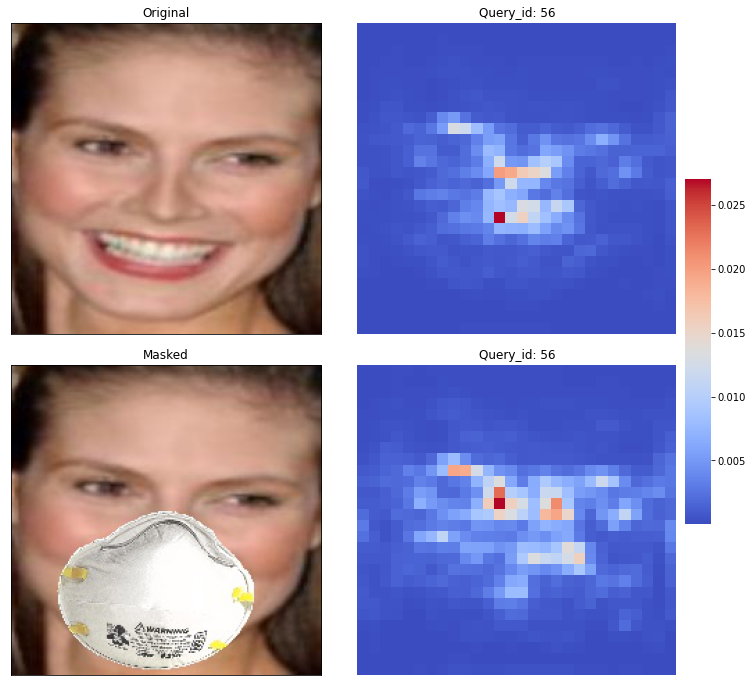

Cosine similarity 0.7620100378990173
2288


In [5]:
sample_idx = 2288 # np.random.randint(len(pairs), size = 1)[0] # 1365 is good

sample_pairs = pairs[sample_idx]
filename1, filename2, _= get_masked_pairs(sample_pairs)

img1 = Image.open(os.path.join(test_root, test_images, filename1)).convert('RGB')
img2 = Image.open(os.path.join(test_root, test_images, filename2)).convert('RGB')

tensor_img1 = transform_face(img1).unsqueeze(0)
tensor_img2 = transform_face(img2).unsqueeze(0)

conv_features, dec_attn_weights = predict(model, tensor_img1, device = device)
conv_features2, dec_attn_weights2 = predict(model, tensor_img2, device = device)

weights = torch.squeeze(dec_attn_weights).to("cpu").numpy()
m_weights = torch.squeeze(dec_attn_weights2).to("cpu").numpy()


# visualize the result
h, w = conv_features['0'].tensors.shape[-2:]
idx = 56 #change from 1 - 64

imgs = [img1, img2]
titles = ["Original", "Masked"]
weights_vis = [weights[idx], m_weights[idx]]

fig, ax = plt.subplots(2,2, figsize = (12,12))
cbar_ax = fig.add_axes([.91, .3, .03, .4])
ax = ax.flat

for i in range(len(ax)):
    if i % 2 == 0:
        # visualize face image
        ax[i].imshow(imgs[i // 2])
        ax[i].set_title(titles[i // 2])
    else:
        sns.heatmap(weights_vis[i // 2].reshape(h, w), cmap = "coolwarm", ax = ax[i], cbar = i == 1, cbar_ax = cbar_ax if i == 1 else None)
        ax[i].set_title(f"Query_id: {idx}")

for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])

plt.subplots_adjust(wspace = 0.1, hspace = 0.1)
plt.show()

# Compute similarity
feature1 = extract_feature(img1, model, device = device)
feature2 = extract_feature(img2, model, device = device)
cosine_dist = feature1.dot(feature2) / (feature1.norm() * feature2.norm() + 1e-5)

print("Cosine similarity", cosine_dist.item())
print(sample_idx)
# fig.savefig(f"visualization/dec_attn_weight_lfw_{idx}.jpg")

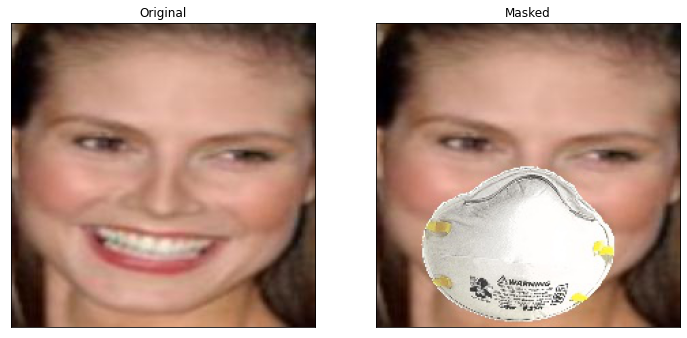

In [6]:
fig, ax = plt.subplots(1,2, figsize = (12,24))
ax = ax.flat

imgs = [img1, img2]
titles = ["Original", "Masked"]

for i in range(len(ax)):
    ax[i].imshow(imgs[i])
    ax[i].set_title(titles[i])

for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])

plt.show()
# fig.savefig(f"visualization/DETR_experiment.jpg")

In [7]:
folder_name = "DETR_exp_3"
save_dir = os.path.join("visualization", folder_name)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
save_dir

'visualization/DETR_exp_3'

# Transformer Decoder Visualization (Non-mask Faces)

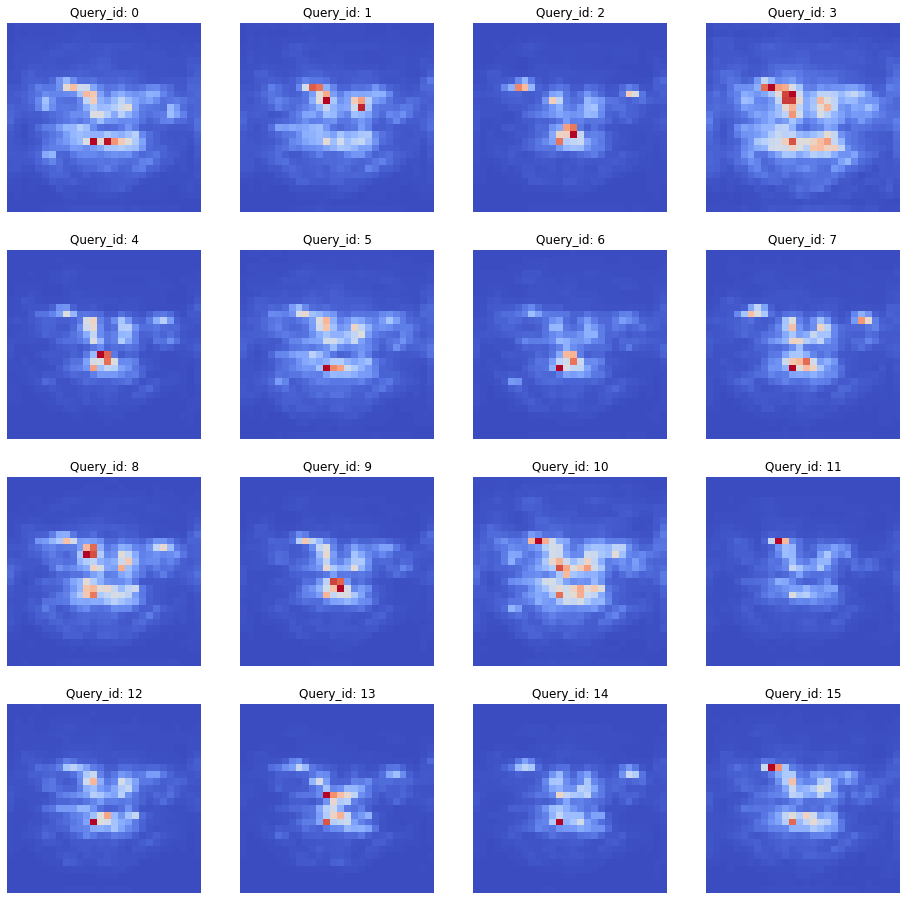

In [8]:
# id 0 - 16
h, w = conv_features['0'].tensors.shape[-2:]

# visualize the result
fig, ax = plt.subplots(4, 4, figsize = (16,16))
ax = ax.flat
# cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i in range(16):
    sns.heatmap(weights[i].reshape(h, w), cmap = "coolwarm", ax = ax[i], cbar = False)
    ax[i].set_title(f"Query_id: {i}")
    
for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])
plt.show()

fig.savefig(os.path.join(save_dir, "dec_attn_weight_0_15.jpg"))

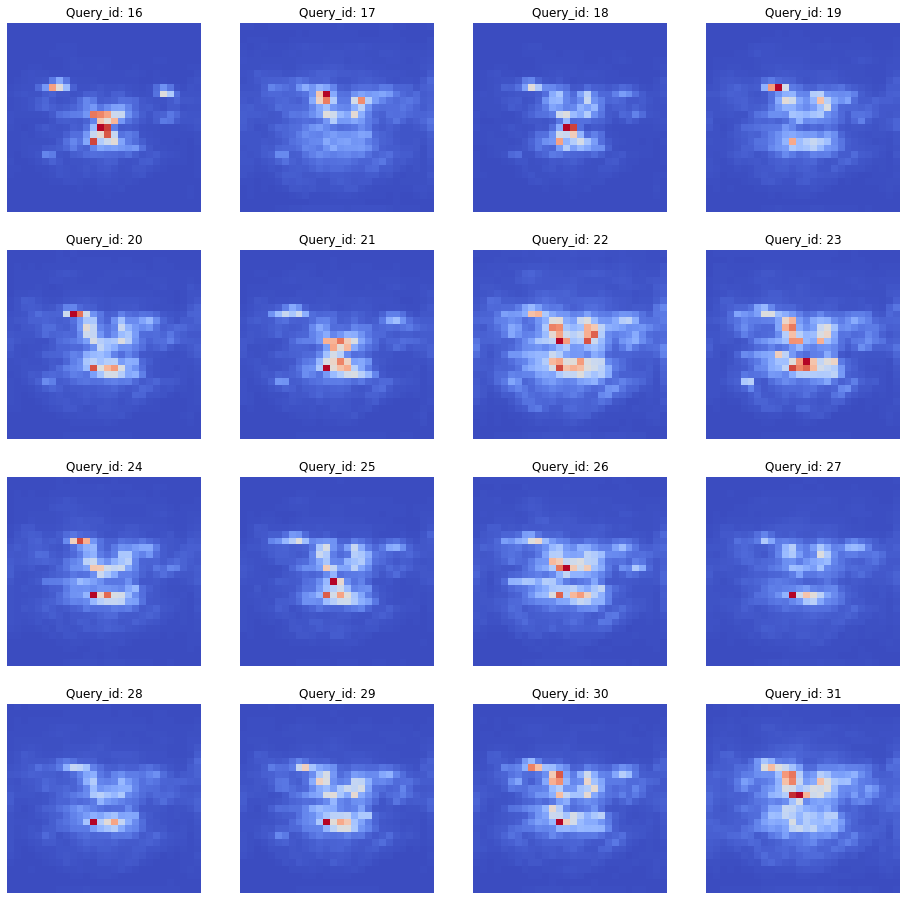

In [9]:
# id 16 - 31
h, w = conv_features['0'].tensors.shape[-2:]

# visualize the result
fig, ax = plt.subplots(4, 4, figsize = (16,16))
ax = ax.flat
# cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i in range(16, 32):
    sns.heatmap(weights[i].reshape(h, w), cmap = "coolwarm", ax = ax[i-16], cbar = False)
    ax[i-16].set_title(f"Query_id: {i}")
    
for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])
plt.show()

fig.savefig(os.path.join(save_dir, "dec_attn_weight_16_31.jpg"))

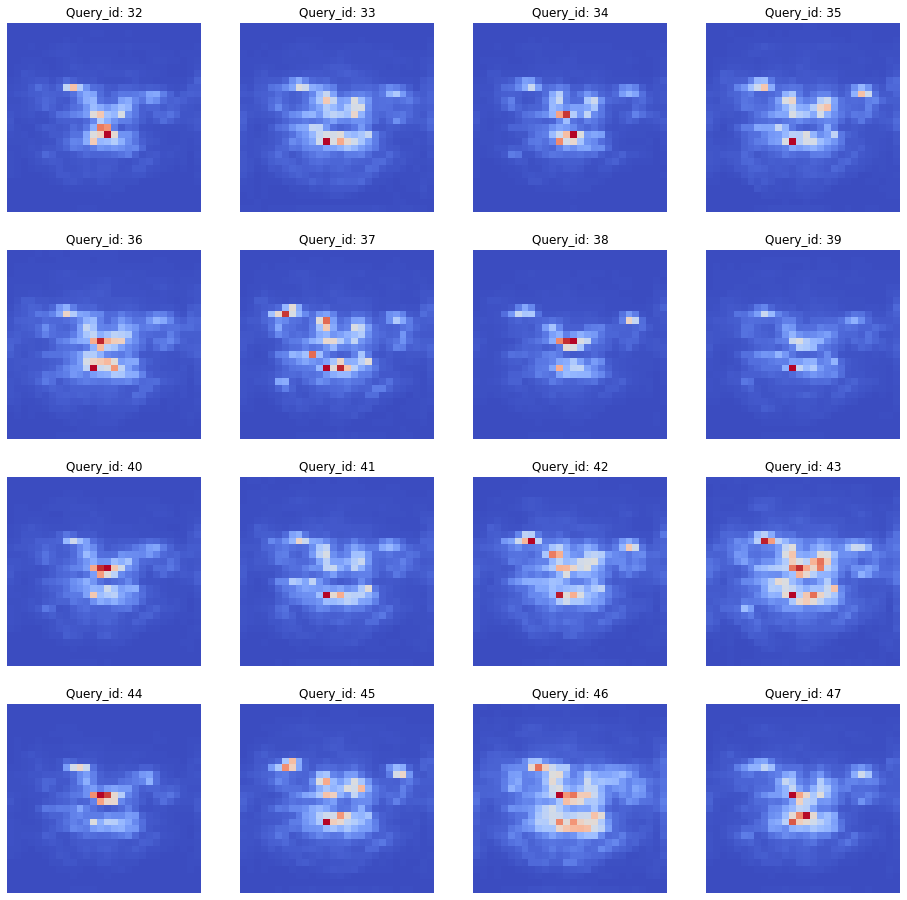

In [10]:
# id 32 - 47
h, w = conv_features['0'].tensors.shape[-2:]

# visualize the result
fig, ax = plt.subplots(4, 4, figsize = (16,16))
ax = ax.flat
# cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i in range(32, 48):
    sns.heatmap(weights[i].reshape(h, w), cmap = "coolwarm", ax = ax[i-32], cbar = False)
    ax[i-32].set_title(f"Query_id: {i}")
    
for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])
plt.show()

fig.savefig(os.path.join(save_dir, "dec_attn_weight_32_47.jpg"))

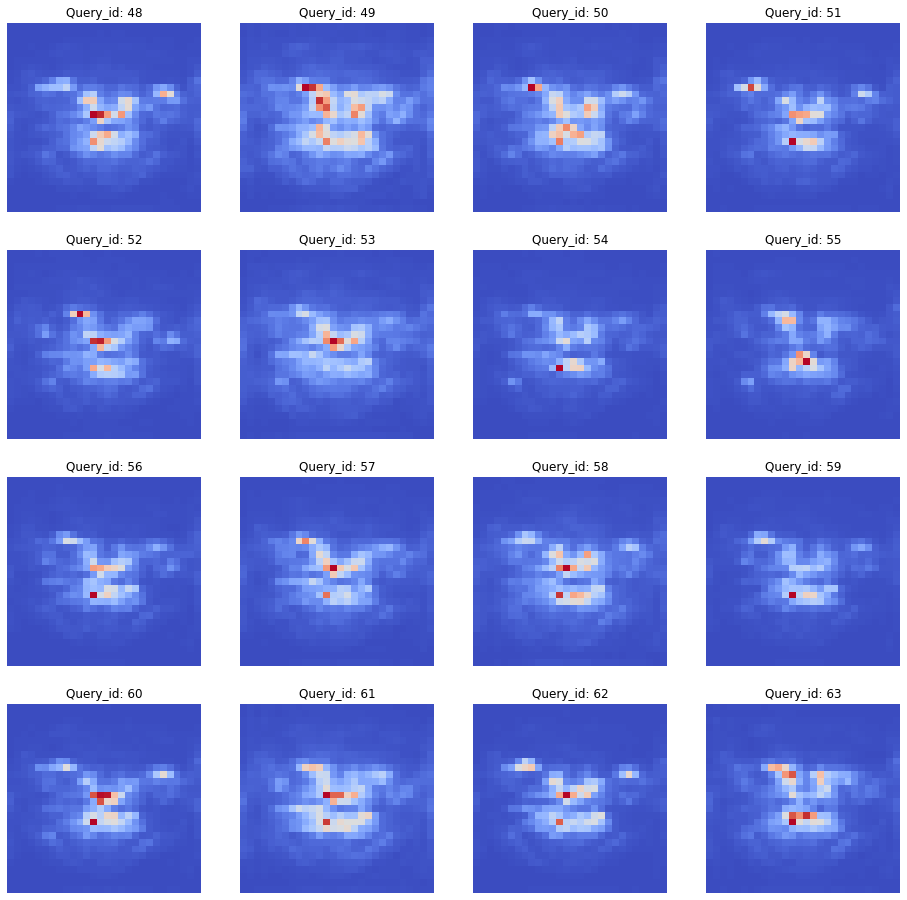

In [11]:
# id 48 - 63
h, w = conv_features['0'].tensors.shape[-2:]

# visualize the result
fig, ax = plt.subplots(4, 4, figsize = (16,16))
ax = ax.flat
# cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i in range(48, 64):
    sns.heatmap(weights[i].reshape(h, w), cmap = "coolwarm", ax = ax[i-48], cbar = False)
    ax[i-48].set_title(f"Query_id: {i}")
    
for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])
plt.show()

fig.savefig(os.path.join(save_dir, "dec_attn_weight_48_63.jpg"))

# Transformer Decoder Visualization (Mask Faces)

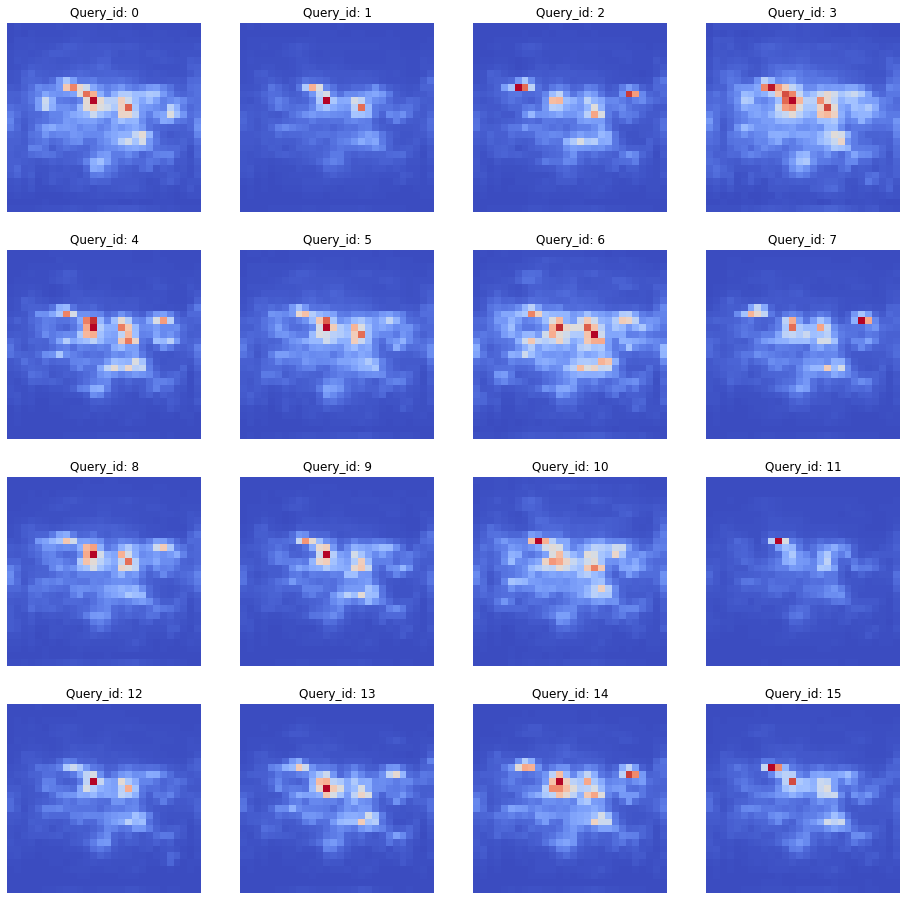

In [12]:
# id 0 - 15
h, w = conv_features['0'].tensors.shape[-2:]

# visualize the result
fig, ax = plt.subplots(4, 4, figsize = (16,16))
ax = ax.flat
# cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i in range(16):
    sns.heatmap(m_weights[i].reshape(h, w), cmap = "coolwarm", ax = ax[i], cbar = False)
    ax[i].set_title(f"Query_id: {i}")
    
for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])
plt.show()

fig.savefig(os.path.join(save_dir, "dec_attn_weight_masked_0_15.jpg"))

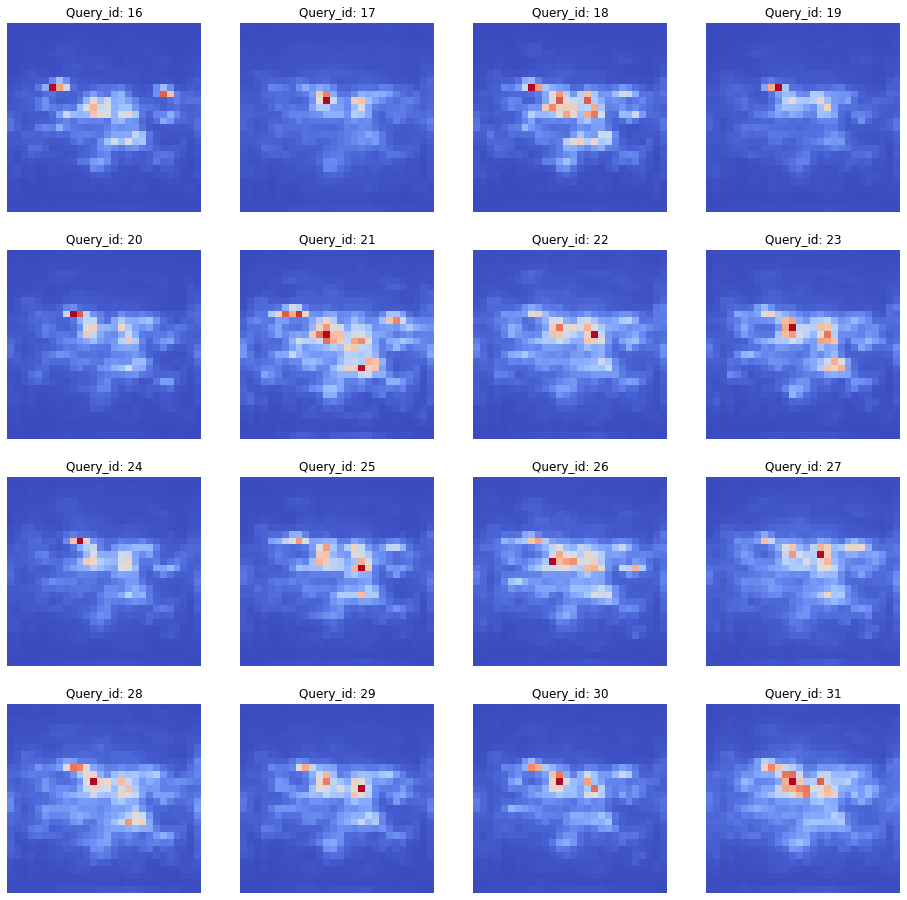

In [13]:
# id 16 - 31
h, w = conv_features['0'].tensors.shape[-2:]

# visualize the result
fig, ax = plt.subplots(4, 4, figsize = (16,16))
ax = ax.flat
# cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i in range(16, 32):
    sns.heatmap(m_weights[i].reshape(h, w), cmap = "coolwarm", ax = ax[i-16], cbar = False)
    ax[i-16].set_title(f"Query_id: {i}")
    
for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])
plt.show()

fig.savefig(os.path.join(save_dir, "dec_attn_weight_masked_16_31.jpg"))

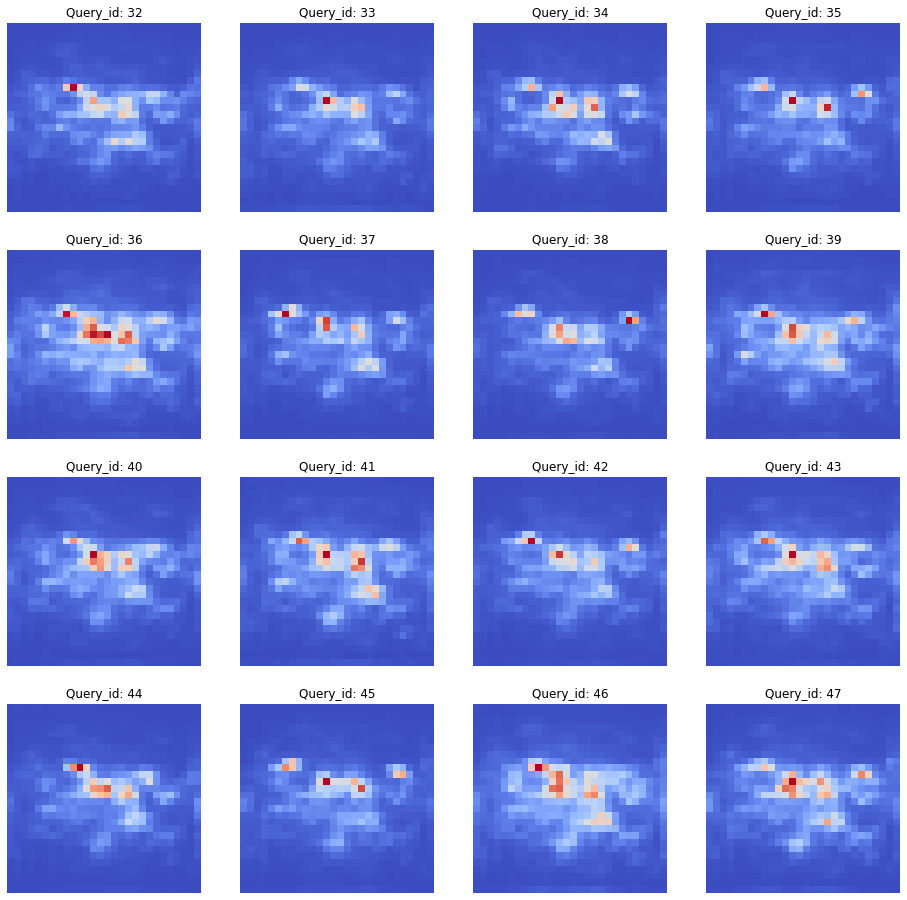

In [14]:
# id 32 - 47
h, w = conv_features['0'].tensors.shape[-2:]

# visualize the result
fig, ax = plt.subplots(4, 4, figsize = (16,16))
ax = ax.flat
# cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i in range(32, 48):
    sns.heatmap(m_weights[i].reshape(h, w), cmap = "coolwarm", ax = ax[i-32], cbar = False)
    ax[i-32].set_title(f"Query_id: {i}")
    
for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])
plt.show()

fig.savefig(os.path.join(save_dir, "dec_attn_weight_masked_32_47.jpg"))

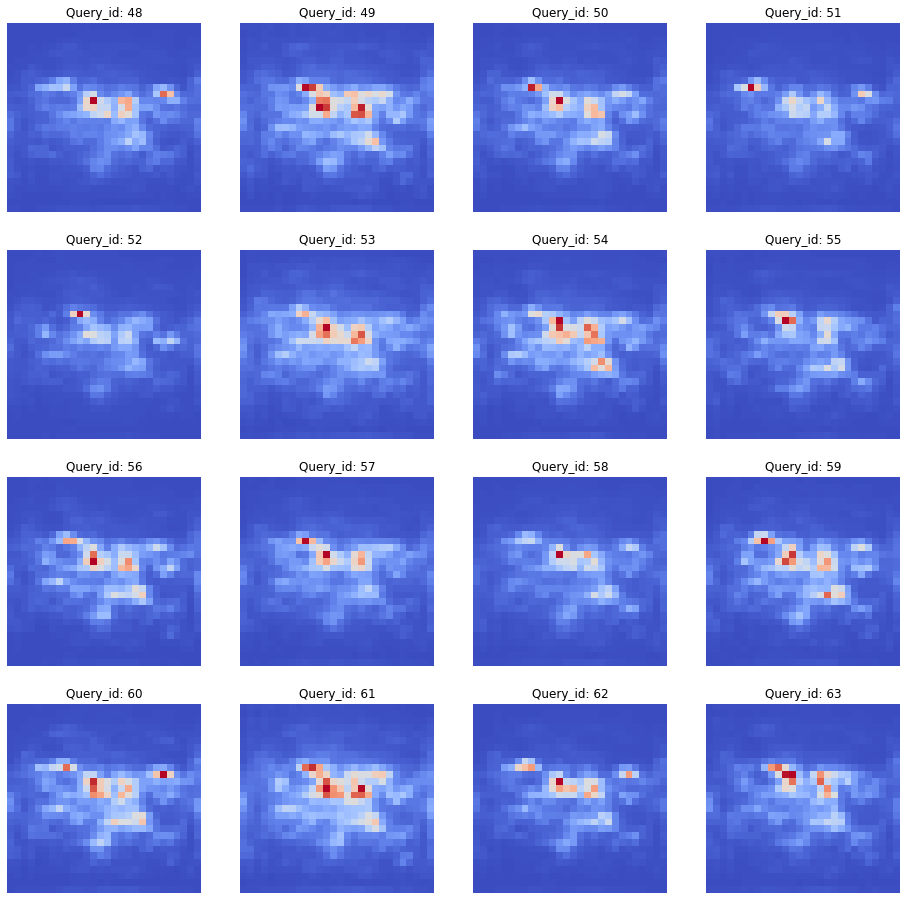

In [15]:
# id 48 - 63
h, w = conv_features['0'].tensors.shape[-2:]

# visualize the result
fig, ax = plt.subplots(4, 4, figsize = (16,16))
ax = ax.flat
# cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i in range(48, 64):
    sns.heatmap(m_weights[i].reshape(h, w), cmap = "coolwarm", ax = ax[i-48], cbar = False)
    ax[i-48].set_title(f"Query_id: {i}")
    
for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])
plt.show()

fig.savefig(os.path.join(save_dir, "dec_attn_weight_masked_48_63.jpg"))

In [ ]:
h, w = conv_features2['0'].tensors.shape[-2:]
attn_weights_masked = torch.squeeze(dec_attn_weights2).to("cpu").numpy()

# visualize the result
fig, ax = plt.subplots(8,8, figsize = (16,16))
ax = ax.flat
# cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i in range(len(ax)):
    sns.heatmap(attn_weights_masked[i].reshape(h, w), cmap = "coolwarm", ax = ax[i], cbar = False)

for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])
plt.show()

# save image
fig.savefig("visualization/decoder_attn_weights.jpg")

In [ ]:


# save image
# fig.savefig("visualization/decoder_attn_idx6.jpg")

In [ ]:
num_true = 0
num_false = 0
thresh = 0.225

In [ ]:
sample_idx = np.random.randint(len(pairs), size = 1)[0]

sample_pairs = pairs[sample_idx]
filename1, filename2, flag = get_pairs_images(sample_pairs)

img1 = Image.open(os.path.join(test_root, test_images, filename1)).convert('RGB')
img2 = Image.open(os.path.join(test_root, test_images, filename2)).convert('RGB')

tensor_img1 = transform_face(img1).unsqueeze(0)
tensor_img2 = transform_face(img2).unsqueeze(0)

conv_features, dec_attn_weights = predict(model, tensor_img1, device = device)
conv_features2, dec_attn_weights2 = predict(model, tensor_img2, device = device)


# visualize the result
id_name1 = filename1.split('_0')[0]
id_name2 = filename2.split('_0')[0]

fig, ax = plt.subplots(1,2, figsize = (12,6))
ax = ax.flat

ax[0].imshow(img1)
ax[0].set_title(id_name1)

ax[1].imshow(img2)
ax[1].set_title(id_name2)

for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])

plt.show()

# Compute similarity
feature1 = extract_feature(img1, model, device = device)
feature2 = extract_feature(img2, model, device = device)
cosine_dist = feature1.dot(feature2) / (feature1.norm() * feature2.norm() + 1e-5)
pred = cosine_dist >= thresh

if pred == flag:
    num_true += 1
else:
    num_false += 1
    
print("Ground truth", flag)
print("Cosine similarity", cosine_dist.item())
print("Number of correct:", num_true)
print("Number of false:", num_false)
print("Accuracy:", num_true/(num_true+num_false))

In [ ]:
h, w = conv_features['0'].tensors.shape[-2:]
attn_weights = torch.squeeze(dec_attn_weights).to("cpu").numpy()

# visualize the result
fig, ax = plt.subplots(8,8, figsize = (16,16))
ax = ax.flat
# cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i in range(len(ax)):
    sns.heatmap(attn_weights[i].reshape(h, w), cmap = "coolwarm", ax = ax[i], cbar = False)

for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])
plt.show()

In [ ]:
h, w = conv_features2['0'].tensors.shape[-2:]
attn_weights = torch.squeeze(dec_attn_weights2).to("cpu").numpy()

# visualize the result
fig, ax = plt.subplots(8,8, figsize = (16,16))
ax = ax.flat
# cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i in range(len(ax)):
    sns.heatmap(attn_weights[i].reshape(h, w), cmap = "coolwarm", ax = ax[i], cbar = False)

for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])
plt.show()

In [ ]:
dec_attn_weights.shape